In [57]:
import cv2
import numpy as np

In [58]:
# Load the model
net = cv2.dnn.readNetFromTensorflow("/content/frozen_inference_graph_coco.pb",
      "/content/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt")

# Store Coco Names in a list
classesFile = "/content/coco.names"
classNames = open(classesFile).read().strip().split('\n')
print(classNames)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush']


In [59]:
# Load image
img = cv2.imread("/content/8433365521_9252889f9a_z.jpg")
height, width, _ = img.shape

# Create black image
blank_mask = np.zeros((height, width, 3), np.uint8)
blank_mask[:] = (0, 0, 0)

# Create blob from the image
blob = cv2.dnn.blobFromImage(img, swapRB=True)

In [60]:
# Detect objects
net.setInput(blob)

boxes, masks = net.forward(["detection_out_final", "detection_masks"])
detection_count = boxes.shape[2]

print(detection_count)

100


Detection 0: horse, Score: 0.9900000095367432
Detection 1: person, Score: 0.8700000047683716


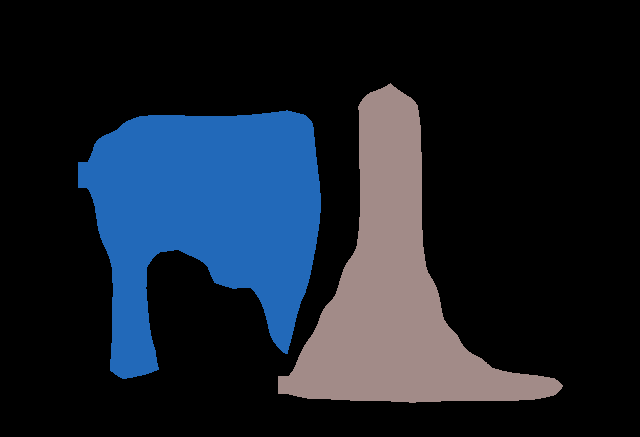

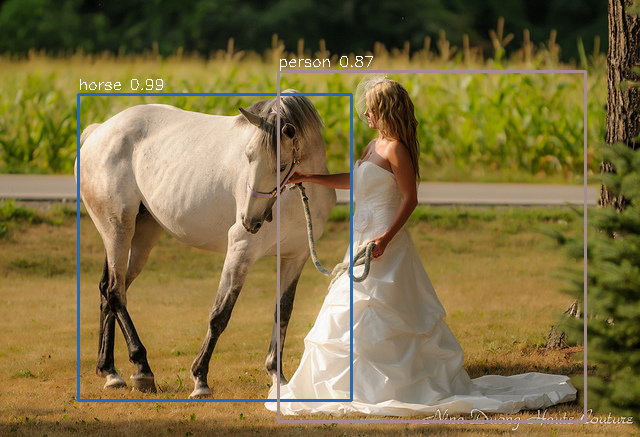

In [61]:
from google.colab.patches import cv2_imshow

count = 0
for i in range(detection_count):
    box = boxes[0, 0, i]
    class_id = int(box[1])
    score = box[2]

    if score < 0.6:
        continue

    class_name = classNames[class_id]
    x = int(box[3] * width)
    y = int(box[4] * height)
    x2 = int(box[5] * width)
    y2 = int(box[6] * height)

    roi = blank_mask[y: y2, x: x2]
    roi_height, roi_width, _ = roi.shape

    mask = masks[i, class_id]
    mask = cv2.resize(mask, (roi_width, roi_height))
    _, mask = cv2.threshold(mask, 0.5, 255, cv2.THRESH_BINARY)

    # Find contours of the mask
    contours, _ = cv2.findContours(np.array(mask, np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    color = np.random.randint(0, 255, 3, dtype='uint8')
    color = [int(c) for c in color]

    # Fill color in segmented area
    for cnt in contours:
        cv2.fillPoly(roi, [cnt], (color[0], color[1], color[2]))

    # Draw bounding box
    cv2.rectangle(img, (x, y), (x2, y2), color, 2)
    cv2.putText(img, class_name + " " + str(round(score, 2)), (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    print(f"Detection {count}: {class_name}, Score: {round(score, 2)}")
    count += 1

# Show results after all detections
cv2_imshow(blank_mask)
cv2_imshow(img)


Final Output:


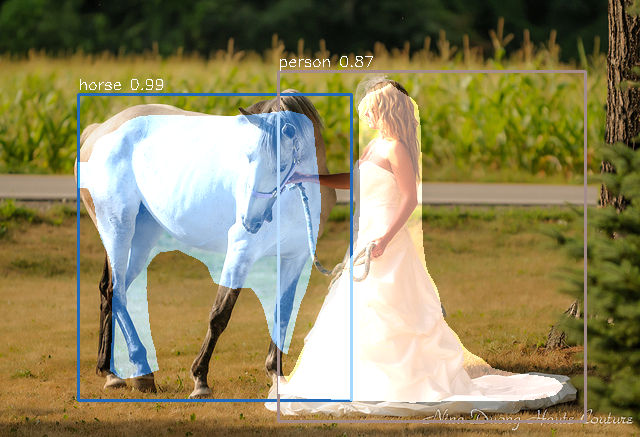

In [62]:
# alpha is the transparency of the first picture
alpha = 1
# beta is the transparency of the second picture
beta = 0.8

mask_img = cv2.addWeighted(img, alpha, blank_mask, beta, 0)

print("Final Output:")
cv2_imshow(mask_img)
